# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [28]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

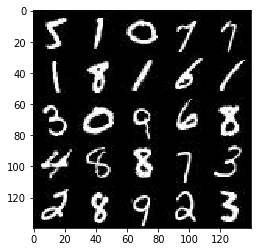

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

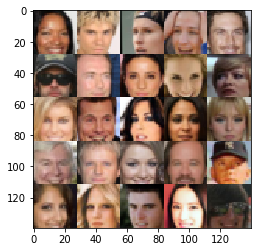

In [30]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [32]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [33]:
def myconv2d(x, size):
    return tf.layers.conv2d(x, size, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    training = not reuse
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = myconv2d(images, 64)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = myconv2d(relu1, 128)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = myconv2d(relu2, 256)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    alpha=0.1
    quantum=7
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, quantum*quantum*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, quantum, quantum, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())   
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real* np.random.uniform(0.7, 1.2))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_dep = [dep for dep in deps if dep.name.startswith("discriminator")]
    g_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(d_dep):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_dep):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ## Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])            
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 20
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                ## Train Model
                steps += 1
                
                # batch images mapped to -1, 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
            print("Final of Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0225... Generator Loss: 6.0132
Epoch 1/2... Discriminator Loss: 3.8116... Generator Loss: 0.0588
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 1.4857
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 1.2957
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 1.1158


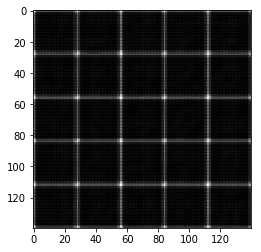

Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 1.1843
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 1.1308


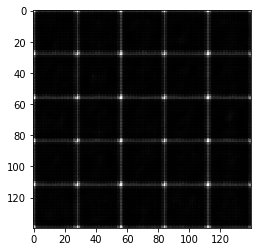

Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 1.6268
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 1.5056
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 1.1935


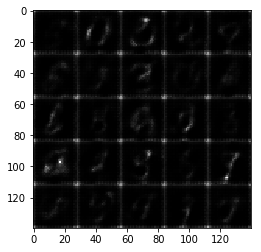

Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 1.2572
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 1.5540
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.1985
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.9841


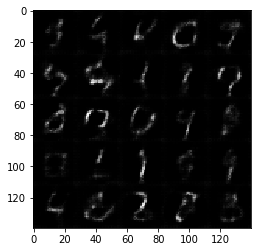

Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.3018
Epoch 1/2... Discriminator Loss: 1.7488... Generator Loss: 0.2460
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.5731


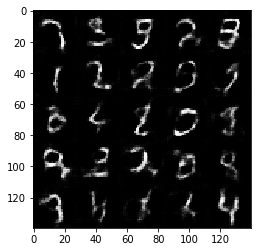

Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 0.9335... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.6605


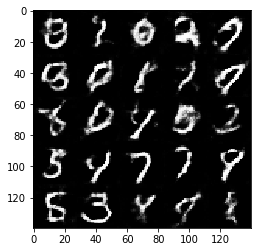

Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 1.7400
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.9116


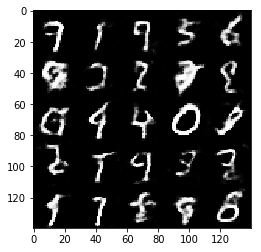

Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 1.7027
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.2187
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 1.9818
Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 2.7082


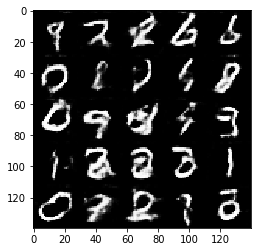

Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 2.0360
Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 1.6373
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 1.7796
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 2.3191


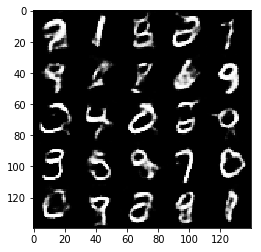

Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.7947
Final of Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 1.1885


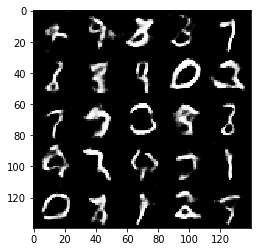

Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 1.3752
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.5012
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.5171


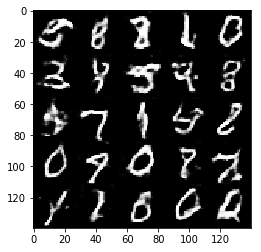

Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.3968
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 1.2535
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 1.6764... Generator Loss: 0.2898


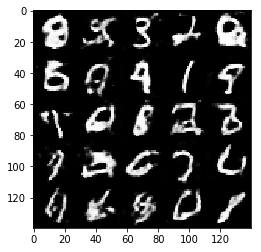

Epoch 2/2... Discriminator Loss: 1.5382... Generator Loss: 0.3450
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 1.5773
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.8739


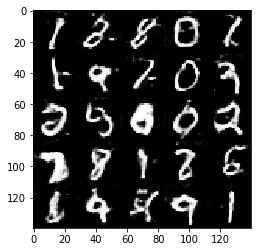

Epoch 2/2... Discriminator Loss: 2.1488... Generator Loss: 0.1685
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.6560
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.5493


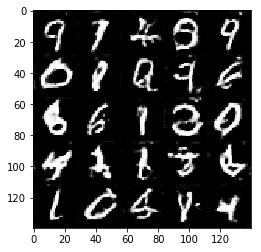

Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.4222
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.2933
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.5203
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 0.9406


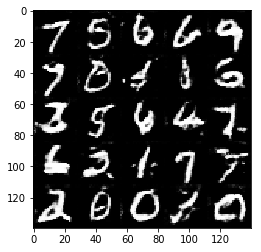

Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 1.4069
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 1.5786


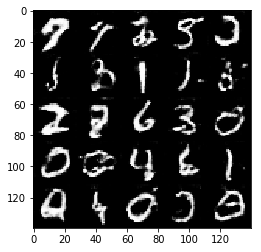

Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.3866
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.1523


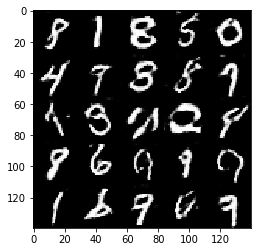

Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.4696
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.0572


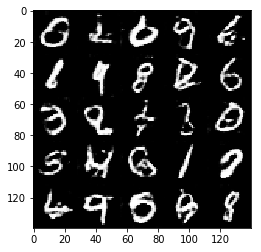

Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.4093
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.5876


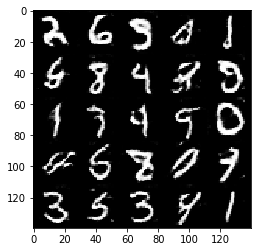

Epoch 2/2... Discriminator Loss: 1.1551... Generator Loss: 0.6137
Final of Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 0.6709


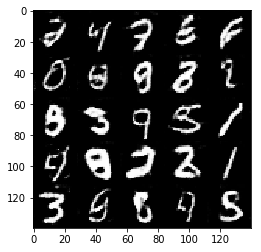

In [39]:
batch_size = 64
z_dim = 100
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 2.4965... Generator Loss: 0.1034


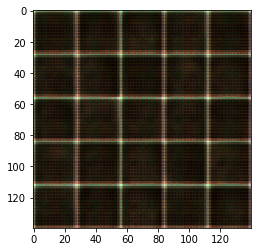

Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 3.7013
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 2.4414
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.3194
Epoch 1/1... Discriminator Loss: 2.3423... Generator Loss: 0.1394


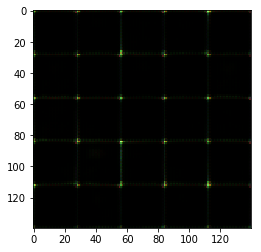

Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.2730
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.2306
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.2873
Epoch 1/1... Discriminator Loss: 2.1150... Generator Loss: 0.1712


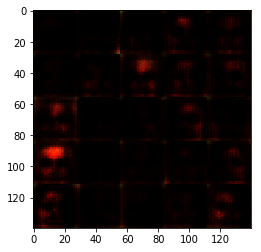

Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 2.7299
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 2.8366
Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 1.9230


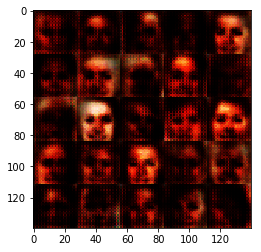

Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 2.8105
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 2.9314
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.6155


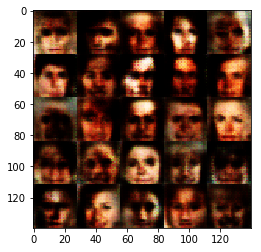

Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 2.5587


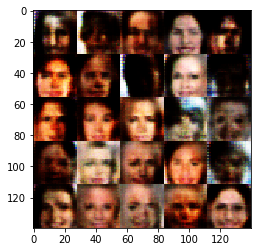

Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 3.3121


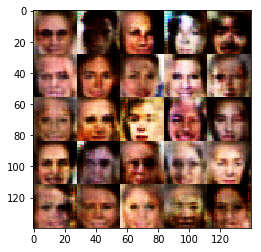

Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.5649


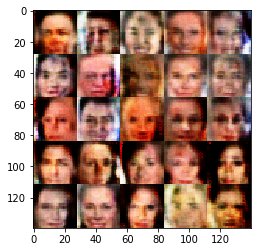

Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.4031
Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 2.3414
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 2.4225
Epoch 1/1... Discriminator Loss: 1.6568... Generator Loss: 0.2689
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 1.1238


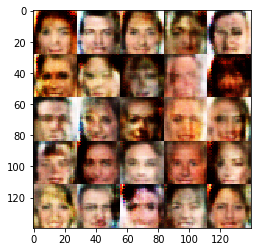

Epoch 1/1... Discriminator Loss: 3.6154... Generator Loss: 3.0128
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 2.4633
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 2.2143
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 0.7376


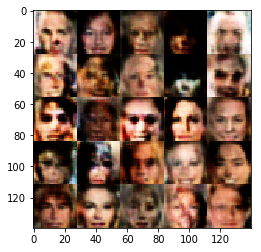

Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 2.3349
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 2.3272


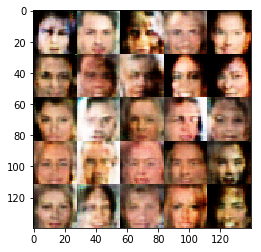

Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 2.3934
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.7508
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.6528


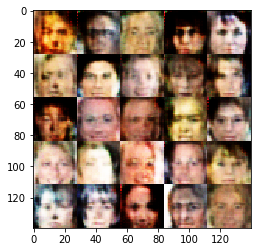

Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 1.2172
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 3.5623
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.3984


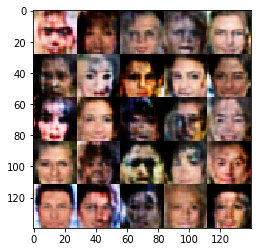

Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 2.4052
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 3.2133


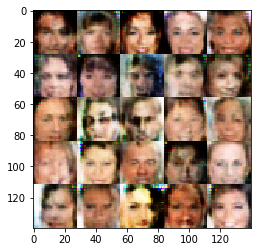

Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 1.8163
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.9814


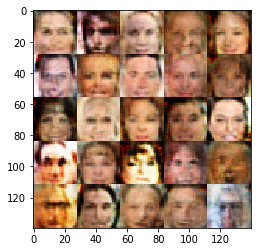

Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 2.4257
Epoch 1/1... Discriminator Loss: 1.8206... Generator Loss: 0.2172
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.7117


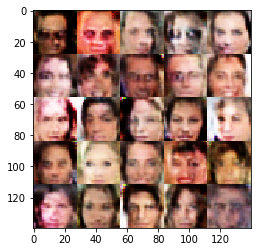

Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.3553
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 3.5563
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.6734


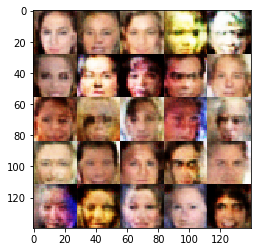

Epoch 1/1... Discriminator Loss: 2.2158... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 1.4546
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 2.0204


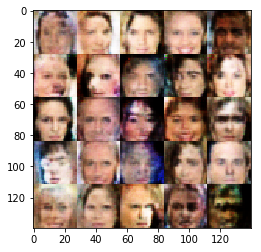

Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.3062
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.4396


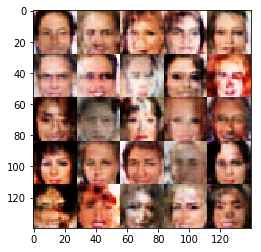

Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.4853
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.9328
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.5721


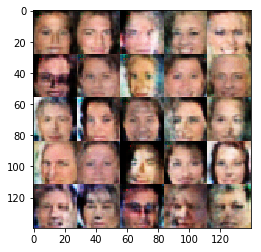

Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 1.9017
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.4113
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.3245


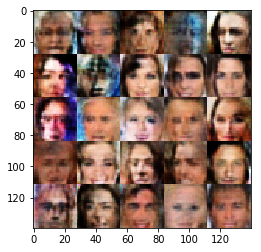

Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.9578
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 2.3085
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 1.5324


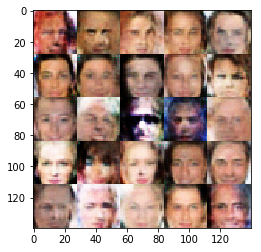

Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.1463
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.5734


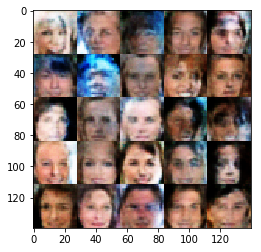

Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.7205
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 3.3487
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 0.2752


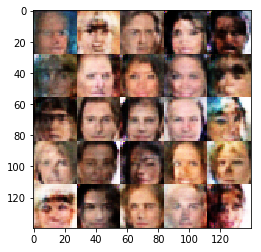

Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.3218


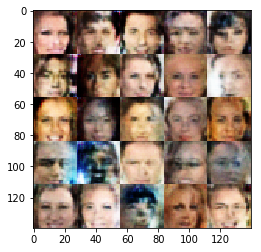

Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 1.4950
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 1.9853


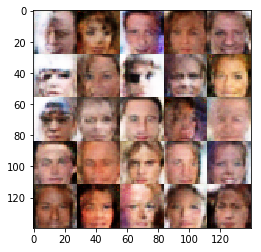

Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 3.1064
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.3762


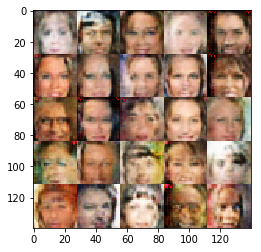

Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.6853
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.7902


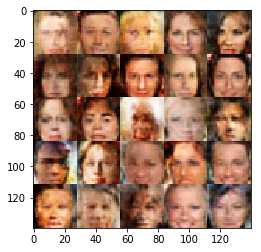

Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.5071
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.9621
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 1.4149
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 1.0187


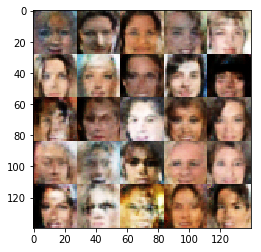

Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.5889


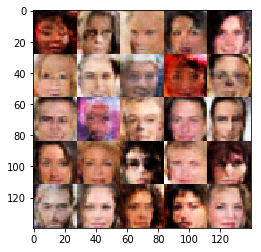

Epoch 1/1... Discriminator Loss: 2.4140... Generator Loss: 0.1090
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.3441
Epoch 1/1... Discriminator Loss: 2.2830... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 1.8288... Generator Loss: 2.2691


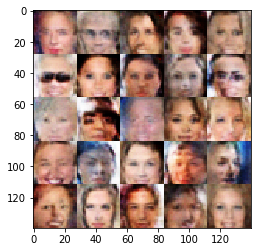

Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.7143... Generator Loss: 0.2331
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 2.1420
Final of Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.8742


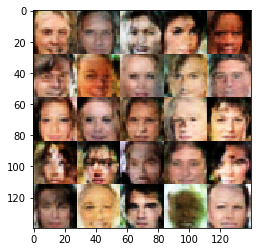

In [40]:
z_dim = 100
batch_size = 64
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.